# Import Libraries

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pandas as pd
import pandas_datareader as pdr
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

# Seasonal Decompose

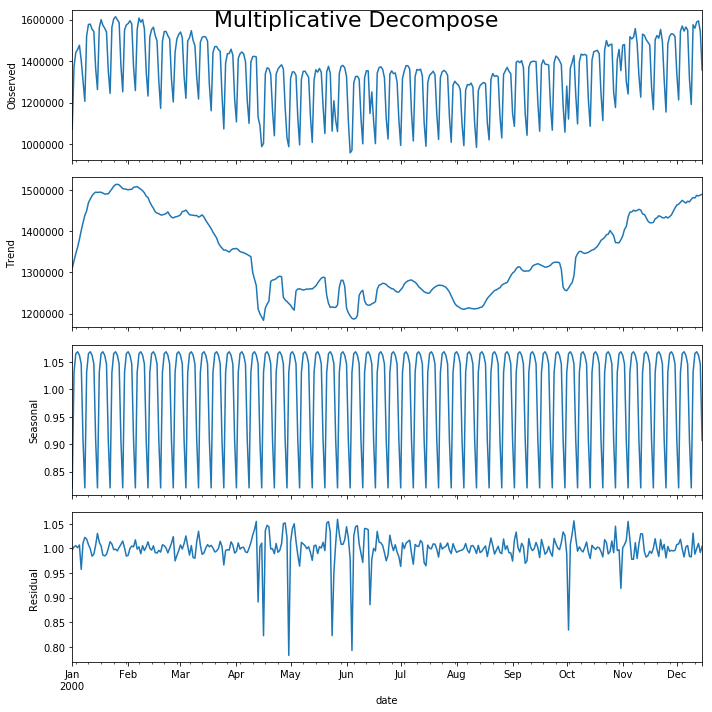

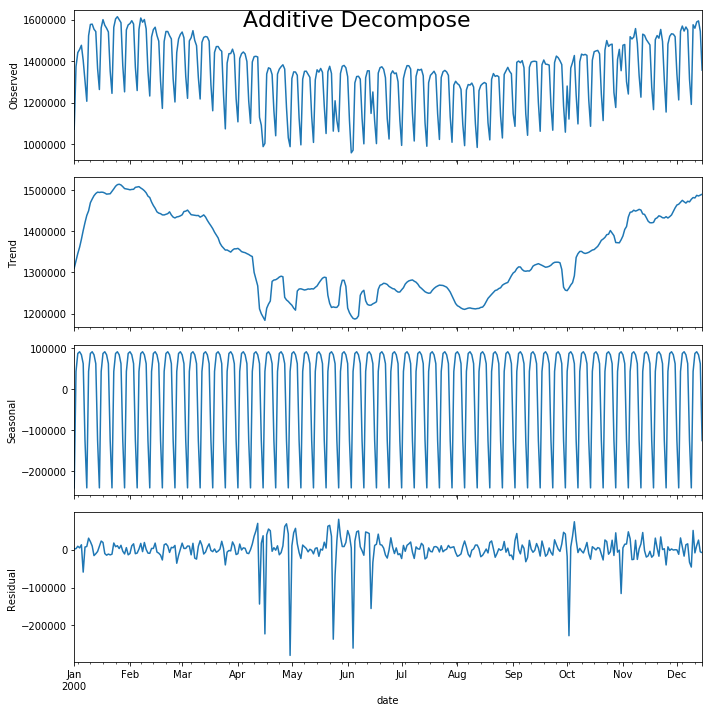

,seas,trend,resid,actual_values
date,,,,
2000-01-01,-240076.315335,1.310196e+06,1897.703090,1072017
2000-01-02,42882.027726,1.328045e+06,2754.941662,1373682
2000-01-03,86500.173644,1.345894e+06,9108.377376,1441503
2000-01-04,90686.399767,1.361044e+06,4733.600233,1456464
2000-01-05,83346.451093,1.380301e+06,12964.406050,1476612


In [89]:
df = pd.read_csv(r'C:\Users\srazavit\Desktop\ML\LSTM\power_consump.csv')
df = df[:350]
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

# Multiplicative Decomposition 
result_mul = seasonal_decompose(df['sin'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df['sin'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

# Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

df_reconstructed_a = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)
df_reconstructed_a.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed_a.head()

# ADF: Testing for Stationary

In [124]:
df_sin = df.sin
#making stationary
def difference_pct_back(datafile, lag = 1):
    diff = [0] * lag
    for i in range(lag,len(datafile)):
        diff.append(datafile[i]/datafile[i-lag]-1)
    return diff
df_s = difference_pct_back(df_sin, 1)

# ADF Test
result = adfuller(df.sin, autolag='AIC')
print(f'p-value non stationary: {result[1]}')
result = adfuller(df_s, autolag='AIC')
print(f'p-value stationary: {result[1]}')

p-value non stationary: 0.006410889783309756
p-value stationary: 1.3300713805275425e-22


# ACF PACF

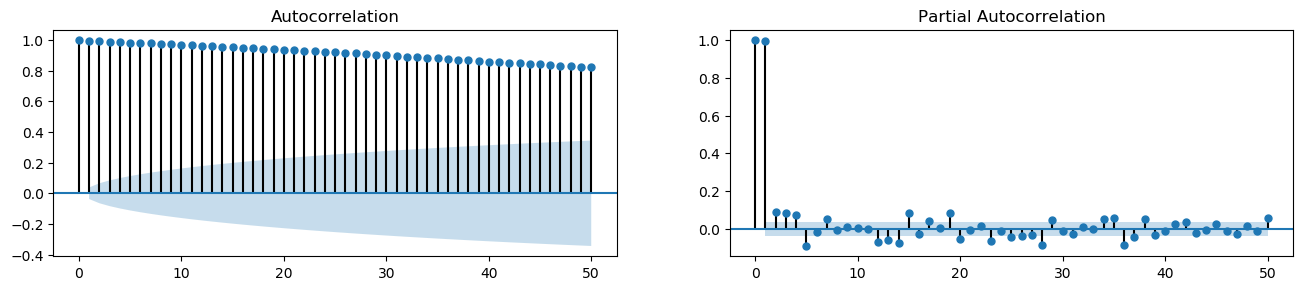

In [8]:
df =  pd.read_csv(r'C:\Users\srazavit\Desktop\ML\LSTM\qqq.csv')

# Calculate ACF and PACF upto 50 lags
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
x = plot_acf(df.sin.tolist(), lags=50, ax=axes[0])
xx = plot_pacf(df.sin.tolist(), lags=50, ax=axes[1])

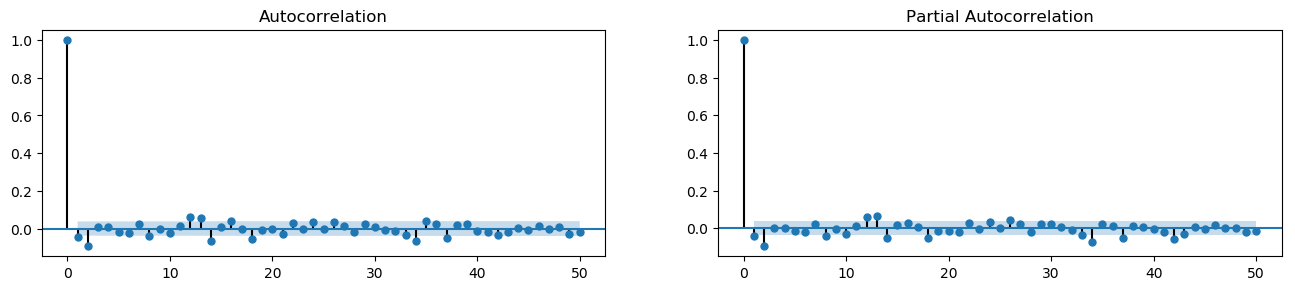

In [10]:
df =  pd.read_csv(r'C:\Users\srazavit\Desktop\ML\LSTM\qqq.csv')
df = df.sin
df_s = difference_pct_back(df, 1)
# Calculate ACF and PACF upto 50 lags
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
x = plot_acf(df_s, lags=50, ax=axes[0])
xx = plot_pacf(df_s, lags=50, ax=axes[1])

# Sample Entropy

In [5]:
def SampEn(U, m, r):
    """Compute Sample entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m+1) / _phi(m))

df_q =  pd.read_csv(r'C:\Users\srazavit\Desktop\ML\LSTM\qqq.csv')
df_p =  pd.read_csv(r'C:\Users\srazavit\Desktop\ML\LSTM\power_consump.csv')
df_s =  pd.read_csv(r'C:\Users\srazavit\Desktop\ML\LSTM\sin_expand.csv')

df_s = df_s.sin
df_p = df_p.sin
df_q = df_q.sin                         

print(SampEn(df_q, m=2, r=0.2*np.std(df_q.sin)))     
print(SampEn(df_p, m=2, r=0.2*np.std(df_p.sin)))
print(SampEn(df_s, m=2, r=0.2*np.std(df_s.sin)))

0.08013109248446586
0.8348748708344248
0.0044803478817058715


In [7]:
df_q =  pd.read_csv(r'C:\Users\srazavit\Desktop\ML\LSTM\qqq.csv')
df_p =  pd.read_csv(r'C:\Users\srazavit\Desktop\ML\LSTM\power_consump.csv')
df_s =  pd.read_csv(r'C:\Users\srazavit\Desktop\ML\LSTM\sin_expand.csv')

df_s = df_s.sin
df_p = df_p.sin
df_q = df_q.sin
#making stationary
df_s = difference_pct_back(df_s, 1)
df_p = difference_pct_back(df_p, 1)
df_q = difference_pct_back(df_q, 1)                       

print(SampEn(df_q, m=2, r=0.2*np.std(df_q)))     
print(SampEn(df_p, m=2, r=0.2*np.std(df_p)))
print(SampEn(df_s, m=2, r=0.2*np.std(df_s)))

1.590881661058799
0.6898838070681819
0.008425289011066464


# ARIMA

In [20]:
df =  pd.read_csv(r'C:\Users\srazavit\Desktop\ML\LSTM\qqq.csv')
df = difference_pct_back(df.sin, 1)
# 1,1,2 ARIMA Model
model = ARIMA(df, order=(2,0,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 2704
Model:                     ARMA(2, 2)   Log Likelihood                6586.666
Method:                       css-mle   S.D. of innovations              0.021
Date:                Fri, 15 Nov 2019   AIC                         -13161.332
Time:                        16:20:38   BIC                         -13125.917
Sample:                             0   HQIC                        -13148.526
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.403e-05      0.000     -0.041      0.967      -0.001       0.001
ar.L1.y       -0.3430      0.141     -2.424      0.015      -0.620      -0.066
ar.L2.y        0.4127      0.140      2.952      0.0